<a href="https://colab.research.google.com/github/rohan1chaudhari/EuroSAT_classification/blob/master/EuroSAT_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EuroSAT Image Classification

## Mount Google Drive

Move the zip file in the drive

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!ls 'gdrive/My Drive/datasets/'

2750  EuroSAT.zip


Unzip the folder 

In [3]:
!unzip 'gdrive/My Drive/datasets/EuroSAT.zip'

Archive:  gdrive/My Drive/datasets/EuroSAT.zip
replace 2750/River/River_479.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: nA
replace 2750/River/River_2178.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Import packages and set random seeds.

In [4]:
import math
import cv2
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import random
import os
from tensorflow.keras import models
from tensorflow.keras.applications import EfficientNetB1
import tensorflow
# Seed value
seed_value = 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## Utility classes for data

In [5]:
class Image:
    """
      This class will be used for mantaining informations about an image
    """

    def __init__(self, category_name):

        # Name of person
        self.category_name = category_name

        # A list with images of the person
        self.category_images = []

    def getCategoryName(self):
        return self.category_name

    def getCategoryImages(self):
        return self.category_images

    def addImage(self, image):
        """
          This function is used for adding an image with person to his/her list

          Arguments:
            image: the image we want to add (numpy array)
        """
        self.category_images.append(image)


def testImageClass():
    """
      This function is used for testing the Image class
    """
    img = Image("Highway")

    assert img.getCategoryName() == "Highway"
    assert img.getCategoryName() != "awd"
    assert len(img.getCategoryImages()) == 0

    img.addImage(3)
    assert len(img.getCategoryImages()) == 1


testImageClass()


class RepositoryImages:
    """
      This class will be used for storing the images
    """

    def __init__(self):

        # A dictionary in this form {category: Image(category, category_images) }
        self.images = {}

    def getAllImages(self):
        """
          This function is used for getting all images 

          Return:
            A list with all images from dict that contains Image objects
        """
        return list(self.images.values())

    def find(self, category):
        """
          This function is used for getting the images of a category

          Arguments:
            category: a string which represents the name of the category that we want to find

          Return:
            A object Image
        """
        return self.images[category]

    def read(self, path_to_dataset):
        """
          This function is used for reading the images from directories

          Arguments:
            path_to_dataset: the path where the images are stored
        """
        directories = os.listdir(path_to_dataset)

        self.images = {}
        print("Total directories: " + str(len(directories)))

        # Iterate thorugh directories of path_to_dataset directory
        for directory in directories:

            # Get the name of each directory
            name_of_images = os.listdir(path_to_dataset + directory)
            print("Current directory: " + directory +
                  " " + str(len(name_of_images)))

            # Iterate through images
            for name_of_image in name_of_images:

                # If the image is already in dictionary
                if directory in self.images.keys():

                    # Read the image
                    image = cv2.imread(path_to_dataset +
                                       directory + "/" + name_of_image)

                    # Add new image
                    self.images[directory].addImage(image)

                else:
                    # Read the image
                    image = Image(directory)
                    image.addImage(cv2.imread(path_to_dataset +
                                              directory + "/" + name_of_image))
                    self.images[directory] = image


def testRepository():
    assert len(repo.getAllImages()) == 10

Check if it was unzipped properly

In [6]:
!ls

2750  gdrive  sample_data


Point to the extracted images

In [7]:
repository = RepositoryImages()
repository.read('2750/')

Total directories: 10
Current directory: Highway 2500
Current directory: PermanentCrop 2500
Current directory: SeaLake 3000
Current directory: Residential 3000
Current directory: Industrial 2500
Current directory: AnnualCrop 3000
Current directory: Forest 3000
Current directory: Pasture 2000
Current directory: River 2500
Current directory: HerbaceousVegetation 3000


In [10]:
class Service:
    """
      This class will be used for working with the while database of images
    """

    def __init__(self, repo):
        self.repo = repo

    def getAllImages(self):
        """
          This function is used for getting all images

          Return:
            A list with all images
        """
        return self.repo.getAllImages()

    def find(self, name_category):
        """
          This function is used for getting the images of a category

          Arguments:
            name_category: a string which represents the name of the category that we want to find

          Return:
            A object Image
        """
        return self.repo.find(name_category)

    def make_flat(self, input_list):
        """
          input_list: a list of lists
        """
        flat_list = []
        for sublist in input_list:
            for item in sublist:
                flat_list.append(item)
        return flat_list

    def displayImagesOfCategory(self, name_category):
        """
          This function is used for displaying the images of a category

          Arguments:
            name_category: a string which represents the name of a category that we want to see his/her images
        """
        # Define the dimensions of the plot grid
        list_of_images = self.find(name_category).getCategoryImages()
        dim = math.floor(math.sqrt(len(list_of_images[:100])))
        W_grid = dim
        L_grid = dim

        # fig, axes = plt.subplots(L_grid, W_grid)
        # subplot return the figure object and axes object
        # we can use the axes object to plot specific figures at various locations

        fig, axes = plt.subplots(L_grid, W_grid, figsize=(25, 25))

        axes = axes.ravel()

        index = 0
        for i in np.arange(0, W_grid * L_grid):

            # read and display an image with the selected index
            axes[i].imshow(cv2.cvtColor(
                np.uint8(list_of_images[index]), cv2.COLOR_BGR2RGB))
            axes[i].set_title(name_category + "_" + str(i), fontsize=10)
            index += 1
            axes[i].axis('off')

        plt.subplots_adjust(hspace=0.4)

    def displayFrequencyHistogram(self):
        """
          This function is used to show a histogram of image frequency for each category
        """

        # Get all images
        images = self.getAllImages()

        frequency = []  # the number of images that corresponds to each category
        categories = []  # the name of each category

        # Iterate through images
        for image in images:
            frequency.append(len(image.getCategoryImages()))
            categories.append(image.getCategoryName())

        fig = go.Figure(data=[go.Bar(x=categories, y=frequency)])

        fig.update_traces(marker_color='rgb(158,202,225)',
                          marker_line_color='rgb(8,48,107)', marker_line_width=1.5, opacity=0.6)
        fig.update_layout(title_text="Image frequency on each category")

        fig.show()

    def get_data_frame_of_frequency(self):
        """
          This function is used for getting the distribution of the dataset

          Return:
            A dataframe
        """
        # The rows for dataframe
        rows = []

        # Get images
        images = self.getAllImages()

        frequency = []  # the number of images that corresponds to each category
        categories = []  # the name of each category

        # Iterate through images
        for image in images:
            frequency.append(len(image.getCategoryImages()))
            categories.append(image.getCategoryName())

        total_images = sum(frequency)

        for i in range(len(categories)):
            category = categories[i]
            number_images_category = frequency[i]

            percent = round((number_images_category * 100) / total_images, 2)

            row = [category, number_images_category, percent, total_images]
            rows.append(row)

        df = pd.DataFrame(data=rows, columns=[
                          "Category", "Number of images", "Percent", "Total images"])
        return df


service = Service(repository)

## **Model Training**

### Load Dataset and split into train, test, validation
### Use EfficientNetB2 as the base model. (SOTA in classification) https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html

In [15]:
percent_train = 0.8
percent_val = 0.1
percent_test = 0.1


annualCrop_imgs = service.find("AnnualCrop").getCategoryImages()
forest_imgs = service.find("Forest").getCategoryImages()
herbaceousVegetation_imgs = service.find(
    "HerbaceousVegetation").getCategoryImages()
highway_imgs = service.find("Highway").getCategoryImages()
industrial_imgs = service.find("Industrial").getCategoryImages()
pasture_imgs = service.find("Pasture").getCategoryImages()
permanentCrop_imgs = service.find("PermanentCrop").getCategoryImages()
residential_imgs = service.find("Residential").getCategoryImages()
river_imgs = service.find("River").getCategoryImages()
sealake_imgs = service.find("SeaLake").getCategoryImages()

imgs = [annualCrop_imgs, forest_imgs, herbaceousVegetation_imgs, highway_imgs, industrial_imgs,
        pasture_imgs, permanentCrop_imgs, residential_imgs, river_imgs, sealake_imgs]


X_train = []
y_train = []

X_val = []
y_val = []
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
X_test = []
y_test = []

i = 0
for set_imgs in imgs:
    train_index = int(len(set_imgs) * percent_train)
    val_index = int(len(set_imgs) * (percent_train + percent_val))
    test_index = int(len(set_imgs) * (percent_train +
                                      percent_val + percent_test))

    X_train += set_imgs[:train_index]
    X_val += set_imgs[train_index + 1: val_index]
    X_test += set_imgs[val_index + 1: test_index]

    y_train += [i for k in range(len(set_imgs[:train_index]))]
    y_val += [i for k in range(len(set_imgs[train_index + 1: val_index]))]
    y_test += [i for k in range(len(set_imgs[val_index + 1: test_index]))]

    i += 1

X_train = np.asarray(X_train, dtype="float32")
y_train = np.asarray(y_train, dtype="float32")

X_val = np.asarray(X_val, dtype="float32")
y_val = np.asarray(y_val, dtype="float32")

X_test = np.asarray(X_test, dtype="float32")
y_test = np.asarray(y_test, dtype="float32")

efficient_net = EfficientNetB1(
    weights="imagenet", include_top=False, input_shape=(64, 64, 3))
model = models.Sequential()
model.add(efficient_net)
model.add(tensorflow.keras.layers.Flatten())
model.add(tensorflow.keras.layers.Dense(1024, activation="relu"))
model.add(tensorflow.keras.layers.Dropout(0.5))
model.add(tensorflow.keras.layers.Dense(10, activation="softmax"))
model.summary()
rms_prop = tensorflow.keras.optimizers.RMSprop(lr=1e-4)
file_path = "gdrive/My Drive/datasets/eff_net_weights.h5"
checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(
    file_path, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")
callbacks = [checkpoint]
model.compile(
    optimizer=rms_prop,
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

INFO:tensorflow:Initializing the TPU system: grpc://10.120.182.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.120.182.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')]
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 2, 2, 1280)        6575239   
_________________________________________________________________
flatten_2 (Flatten)        

### Train model until overfitting.
We could use **EarlyStopping** callback but I didn't want to let the model train for a very long time

In [16]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=128,
    verbose=1,
    epochs=2,
    callbacks=callbacks
)

Epoch 1/2
  2/169 [..............................] - ETA: 6:02 - loss: 2.9490 - accuracy: 0.1406 WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0029s vs `on_train_batch_end` time: 0.6692s). Check your callbacks.


169/169 [==============================] - ETA: 0s - loss: 0.7138 - accuracy: 0.7735WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0019s vs `on_test_batch_end` time: 0.1222s). Check your callbacks.



Epoch 00001: val_accuracy improved from -inf to 0.81896, saving model to gdrive/My Drive/datasets/eff_net_weights.h5
169/169 [==============================] - 109s 642ms/step - loss: 0.7138 - accuracy: 0.7735 - val_loss: 0.6312 - val_accuracy: 0.8190
Epoch 2/2
169/169 [==============================] - ETA: 0s - loss: 0.2403 - accuracy: 0.9251
Epoch 00002: val_accuracy improved from 0.81896 to 0.93383, saving model to gdrive/My Drive/datasets/eff_net_weights.h5
169/169 [==============================] - 102s 602ms/step - loss: 0.2403 - accuracy: 0.9251 - val_loss: 0.2115 - val_accuracy: 0.9338


In [18]:
history2 = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=128,
    verbose=1,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
  2/169 [..............................] - ETA: 2:02 - loss: 0.1000 - accuracy: 0.9570WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0038s vs `on_train_batch_end` time: 0.6774s). Check your callbacks.


169/169 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9577WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_test_batch_end` time: 0.1198s). Check your callbacks.



Epoch 00001: val_accuracy improved from 0.93383 to 0.95836, saving model to gdrive/My Drive/datasets/eff_net_weights.h5
169/169 [==============================] - 104s 617ms/step - loss: 0.1282 - accuracy: 0.9577 - val_loss: 0.1385 - val_accuracy: 0.9584
Epoch 2/5
169/169 [==============================] - ETA: 0s - loss: 0.0747 - accuracy: 0.9764
Epoch 00002: val_accuracy improved from 0.95836 to 0.95948, saving model to gdrive/My Drive/datasets/eff_net_weights.h5
169/169 [==============================] - 102s 606ms/step - loss: 0.0747 - accuracy: 0.9764 - val_loss: 0.1381 - val_accuracy: 0.9595
Epoch 3/5
169/169 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.9779
Epoch 00003: val_accuracy improved from 0.95948 to 0.96617, saving model to gdrive/My Drive/datasets/eff_net_weights.h5
169/169 [==============================] - 102s 604ms/step - loss: 0.0704 - accuracy: 0.9779 - val_loss: 0.1217 - val_accuracy: 0.9662
Epoch 4/5
169/169 [=========================

In [34]:
history3 = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=128,
    verbose=1,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
  2/169 [..............................] - ETA: 2:03 - loss: 0.0583 - accuracy: 0.9883WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0031s vs `on_train_batch_end` time: 0.6696s). Check your callbacks.


169/169 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9929WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0018s vs `on_test_batch_end` time: 0.1175s). Check your callbacks.



Epoch 00001: val_accuracy improved from 0.97138 to 0.97398, saving model to gdrive/My Drive/datasets/eff_net_weights.h5
169/169 [==============================] - 103s 608ms/step - loss: 0.0243 - accuracy: 0.9929 - val_loss: 0.1233 - val_accuracy: 0.9740
Epoch 2/5
169/169 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9934
Epoch 00002: val_accuracy improved from 0.97398 to 0.97509, saving model to gdrive/My Drive/datasets/eff_net_weights.h5
169/169 [==============================] - 103s 611ms/step - loss: 0.0189 - accuracy: 0.9934 - val_loss: 0.1299 - val_accuracy: 0.9751
Epoch 3/5
169/169 [==============================] - ETA: 0s - loss: 0.0228 - accuracy: 0.9932
Epoch 00003: val_accuracy did not improve from 0.97509
169/169 [==============================] - 99s 586ms/step - loss: 0.0228 - accuracy: 0.9932 - val_loss: 0.1280 - val_accuracy: 0.9747
Epoch 4/5
169/169 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 0.9940
Epoch 00004: va

## Accuracy graphs. 3 graphs because we trained the model in 3 iterations

In [20]:
x = np.arange(10)

fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y= history.history['accuracy'], name="Train"))
fig.add_trace(go.Scatter(x=x, y= history.history['val_accuracy'], name="Validation"))

fig.show()

In [19]:

x = np.arange(10)

fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y= history2.history['accuracy'], name="Train"))
fig.add_trace(go.Scatter(x=x, y= history2.history['val_accuracy'], name="Validation"))

fig.show()

In [42]:

x = np.arange(10)

fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y= history3.history['accuracy'], name="Train"))
fig.add_trace(go.Scatter(x=x, y= history3.history['val_accuracy'], name="Validation"))

fig.show()

## Load the best model that is saved in drive

In [36]:
model.load_weights("gdrive/My Drive/datasets/eff_net_weights.h5")

In [37]:

# Get the accuracy and loss on test set
loss, acc = model.evaluate(X_test,  y_test,batch_size=128, verbose=2)
print('Model, accuracy: {:5.2f}%'.format(100*acc))

22/22 - 3s - loss: 0.1582 - accuracy: 0.9714
Model, accuracy: 97.14%


We have the accuracy : 97.14%

In [38]:
y_pred = model.predict(X_test,batch_size=128,verbose=1)


 2/22 [=>............................] - ETA: 1sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0018s vs `on_predict_batch_end` time: 0.1274s). Check your callbacks.


22/22 [==============================] - 3s 115ms/step


In [39]:
labels = ["Annual Crop", "Forest", "HerbaceousVegetation", "Highway", "Industrial", "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"]

## Confusion Matrix and Classification Report

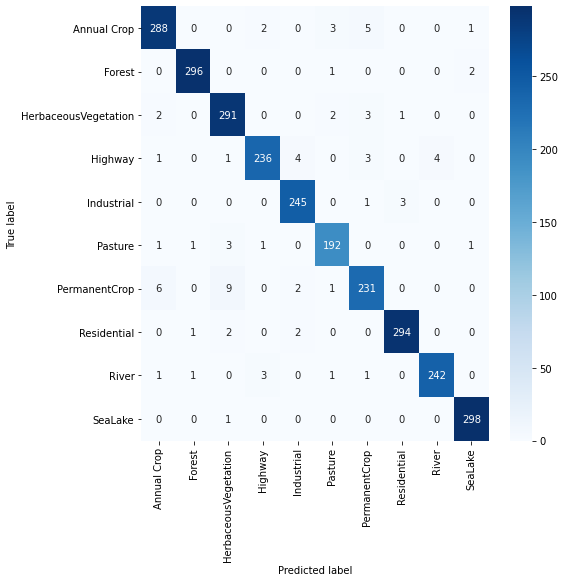

In [40]:

# Get the confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred.argmax(axis = 1))

# Plot the confusion matrix
figure = plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True,cmap=plt.cm.Blues, fmt="d", xticklabels = labels, yticklabels=labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [41]:
# Print the classification Report
class_names = ['AnnualCrop', 'Forest','HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
print(metrics.classification_report(y_test, y_pred.argmax(axis=1), target_names=class_names))

                      precision    recall  f1-score   support

          AnnualCrop       0.96      0.96      0.96       299
              Forest       0.99      0.99      0.99       299
HerbaceousVegetation       0.95      0.97      0.96       299
             Highway       0.98      0.95      0.96       249
          Industrial       0.97      0.98      0.98       249
             Pasture       0.96      0.96      0.96       199
       PermanentCrop       0.95      0.93      0.94       249
         Residential       0.99      0.98      0.98       299
               River       0.98      0.97      0.98       249
             SeaLake       0.99      1.00      0.99       299

            accuracy                           0.97      2690
           macro avg       0.97      0.97      0.97      2690
        weighted avg       0.97      0.97      0.97      2690

